In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 

  Activating environment at `C:\Users\shang\Documents\OCRL\Project\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","planar_vehicle.jl"))

check_dynamic_feasibility (generic function with 1 method)

<!-- function dynamics(params,X, u)
   
   
    # params :L (distance between front and rear axis)
    # X :[x,y,theta]
    # U : [v,delta]

    
    s= sin(X[3])
    c = cos(X[3])
    
    xd = U[1]*c# vcos(theta) 
    yd = U[1]*s # vsin(theta) 
    thetad = U[1]*tan(U[2])/params.L # v*tan(δ)/L
    
    dX = [xd;yd;thetad]
    return [X;dX]

end -->

In [3]:
function single_vehicle_dynamics(params, x,u)
    # planar quadrotor dynamics for a single quadrotor 
    # params :L (distance between front and rear axis)
    # X :[x,y,theta]
    # U : [v,delta]
    # unpack state
    x, y, theta = x  
    v, delta = u
    L = params.L
    
    xdot = [
        v*cos(theta),
        v*sin(theta),
        v*tan(delta)/L
    ]
    
    return xdot
end
function combined_dynamics(params, x,u)
    
    # car 1 
    x1 = x[1:3]
    u1 = u[1:2]
    xdot1 = single_vehicle_dynamics(params, x1, u1)
    
    # car 2
    x2 = x[(1:3) .+ 3]
    u2 = u[(1:2) .+ 2]
    xdot2 = single_vehicle_dynamics(params, x2, u2)

    
    return [xdot1;xdot2]
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual
    ẋ1 = combined_dynamics(params, x1, u)
    ẋ2 = combined_dynamics(params, x2, u)
    xh = 0.5*(x1+x2) + (dt/8)*(ẋ1-ẋ2)
    ẋh = combined_dynamics(params,xh,u)
    
    return ẋh - ((-3/(2*dt))*(x1-x2) - 0.25*(ẋ1+ẋ2))

end

hermite_simpson (generic function with 1 method)

In [4]:
start = [0.;0.;0.]
final = [200.;0.;0.]
xref = range(start,final,length=50)

50-element LinRange{Vector{Float64}}:
 [0.0, 0.0, 0.0],[4.08163, 0.0, 0.0],…,[195.918, 0.0, 0.0],[200.0, 0.0, 0.0]

In [4]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function vehicle_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xref1, xref2 = params.idx, params.N, params.xref1, params.xref2
    Q1, Q2, R1, R2, Qf = params.Q1,params.Q2, params.R1, params.R2, params.Qf
    
    # TODO: input cartpole LQR cost 
#     println("started")
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        J += 0.5*(xi[1:3] - xref1[i])'*Q1*(xi[1:3] - xref1[i]) + 0.5*ui[1:2]'*R1*ui[1:2]
        J += 0.5*(xi[4:6] - xref2[i])'*Q2*(xi[4:6] - xref2[i]) + 0.5*ui[3:4]'*R2*ui[3:4]
    end
    xn = Z[idx.x[N]]
    J += 0.5 * (xn[1:3]-xref1[N])'*Qf*(xn[1:3]-xref1[N])
    J += 0.5 * (xn[4:6]-xref2[N])'*Qf*(xn[4:6]-xref2[N])
  
    return J 
end

function vehicle_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 
    
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
            
    end
    
    return c 
end

function vehicle_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx = params.N, params.idx
    x1ic, x2ic = params.x1ic, params.x2ic

    dym_c = vehicle_dynamics_constraints(params,Z)
    eq_c = [[x1ic;x2ic]-Z[idx.x[1]]; dym_c]
    return eq_c 
end

function inequality_constraint(params::NamedTuple, Z::Vector)

    N, idx, xref1, xref2 = params.N, params.idx, params.xref1, params.xref2
    # one for distance between two cars, two for the upper and lower bounds of road
    
    ineq_c = zeros(eltype(Z),N+1)
    for i = 1:N-1
        x = Z[idx.x[i]]
        pos1 = x[1:2]
        pos2 = x[4:5]
        dist = norm(pos1-pos2)^2
        ineq_c[i] = dist
    end
    xn = Z[idx.x[N]]
    pos1 = xn[1:2]
    pos2 = xn[4:5]
    xrefn1 = xref1[N][1:2]
    xrefn2 = xref2[N][1:2]
    ineq_c[end-1:end] = [norm(pos1-xrefn1)^2;norm(pos2-xrefn2)^2]
    return ineq_c
end

"""
    vehicle_path

Function for returning collision free trajectories for 2 cars. 

Outputs:
    x1::Vector{Vector}  # state trajectory for car 1 
    x2::Vector{Vector}  # state trajectory for car 2 
    u1::Vector{Vector}  # control trajectory for car 1 
    u2::Vector{Vector}  # control trajectory for car 2 
    t_vec::Vector
    params::NamedTuple

The resulting trajectories should have dt=0.2, tf = 50, N = 100

"""
function vehicle_path(;verbose=true)
    
    # problem size 
    nx = 6 
    nu = 4
    dt = 0.5
    tf = 8
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial conditions and goal states 
    x1ic = [0,-1.5,0] # ic for quad 1 
    x2ic = [10,-1.5,0] # ic for quad 2 

    start1 = [0.;-1.5;0.]
    final1 = [100.;-1.5;0.]
    xref1 = range(start1,final1,length=N)
    
    start2 = [10.;-1.5;0.]
    final2 = [80.;-1.5;0.]
    xref2 = range(start2,final2,length=N)
    Q1 = diagm(ones(3))
    Q2 = 10*diagm(ones(3))   
    R1 = 0.5*diagm(ones(2))
    R2 = 1*diagm(ones(2))    
    Qf = 10*diagm(ones(3))
    
    
    # load all useful things into params 
    # TODO: include anything you would need for a cost function (like a Q, R, Qf if you were doing an 
    # LQR cost)
    params = (x1ic=x1ic,
              x2ic=x2ic,
              xic = [x1ic;x2ic],
              xref1 = xref1,
              xref2 = xref2,
              dt = dt,
              N = N,
              idx = idx,
              L = 2.5, # distance between front and back 
              Q1 = Q1,
              Q2 = Q2,
              R1 = R1,
              R2 = R2,
              Qf = Qf)    
    
    ### Primal Bounds
    x_l = [[-Inf, -2.5,-pi/5,-Inf, -1.5,-pi/10,5,-pi/8,0,-pi/8] for i = 1:N-1]
    x_l = reduce(vcat,x_l)
    x_l = [x_l;[-Inf; -3;-pi/5;-Inf ;-3;-pi/5]]
    x_u = [[Inf, 3,pi/5,Inf,-1.5,pi/10,20,pi/8,10,pi/8] for i = 1:N-1]
    x_u = reduce(vcat,x_u)
    x_u = [x_u;[Inf;3;pi/5;Inf;3;pi/5]]
    
    # Assume each car is 2 meters wide and 2.5 meters long
    c_l = 12*ones(N+1)
    c_l[end-1:end] .= 0
    c_u = Inf*ones(N+1)
    c_u[end-1:end] .= 3 
    
    ## initial guess
    z0 = 0.01*randn(idx.nz)
    diff_type = :auto

    
    Z = fmincon(vehicle_cost,vehicle_equality_constraint,inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    x1 = [Z[idx.x[i]][1:3]  for i = 1:N]
    x2 = [Z[idx.x[i]][4:6]  for i = 1:N]
    u1 = [Z[idx.u[i]][1:2]  for i = 1:(N-1)]
    u2 = [Z[idx.u[i]][3:4]  for i = 1:(N-1)]
        
    return x1, x2, u1, u2, t_vec, params 
end

vehicle_path

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15300
Number of nonzeros in inequality constraint Jacobian.:     2700
Number of nonzeros in Lagrangian Hessian...

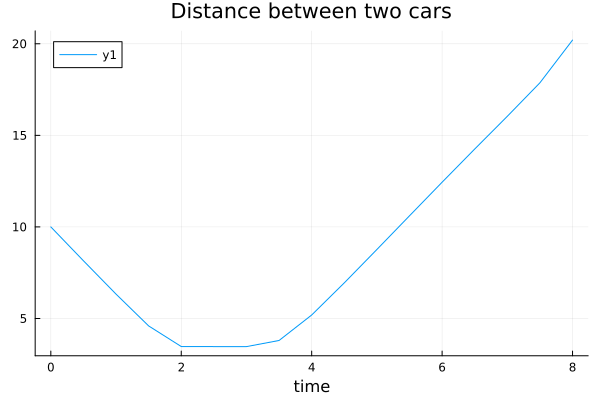

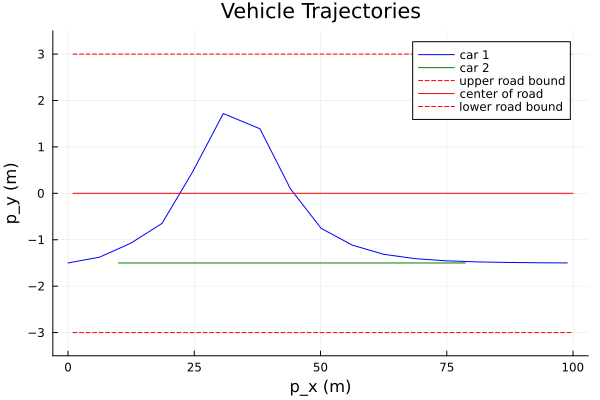

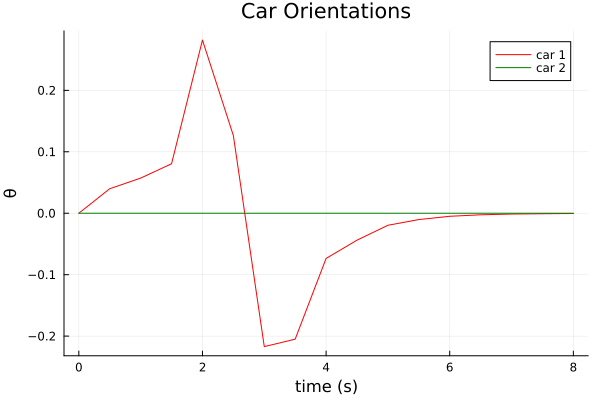

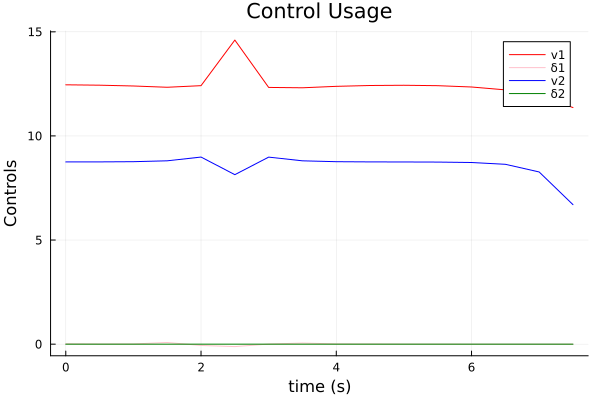

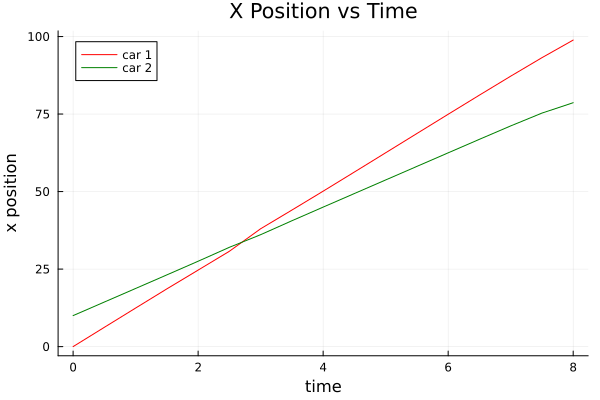

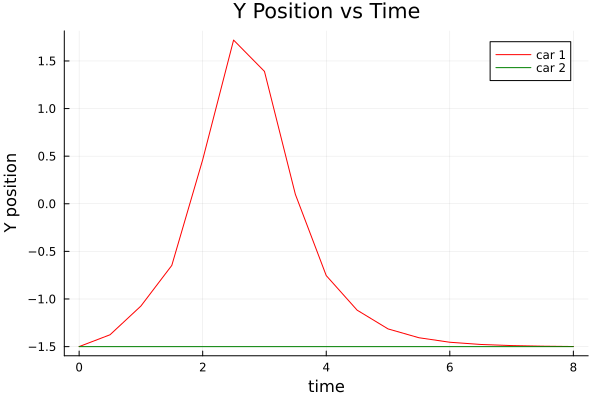

In [5]:
X1, X2, U1, U2, t_vec, params  = vehicle_path(verbose=true)
    

distances = [distance_between_cars(x1[1:2],x2[1:2]) for (x1,x2) in zip(X1,X2)]
display(plot(t_vec,reduce(vcat, distances),xlabel = "time", title = "Distance between two cars"))

        
X1m = hcat(X1...)
X2m = hcat(X2...)
    
plot(X1m[1,:], X1m[2,:], color = :blue,title = "Vehicle Trajectories", label = "car 1", ylims = [-3.5,3.5])
plot!(X2m[1,:], X2m[2,:], color = :green, label = "car 2",xlabel = "p_x (m)", ylabel = "p_y (m)", legend=:topright)
plot!(3*ones(100),ls = :dash, color = :red, label = "upper road bound")
plot!(zeros(100), color = :red, label = "center of road")
display(plot!(-3*ones(100),ls = :dash, color = :red, label = "lower road bound"))
        
plot(t_vec, X1m[3,:], color = :red,title = "Car Orientations", label = "car 1")
display(plot!(t_vec, X2m[3,:], color = :green, label = "car 2",xlabel = "time (s)", ylabel = "θ"))
    
plot(t_vec[1:end-1],reduce(hcat,U1)'[:,1], color = :red,title = "Control Usage", label = "v1")
plot!(t_vec[1:end-1],reduce(hcat,U1)'[:,2], color = :pink,title = "Control Usage", label = "δ1")
plot!(t_vec[1:end-1],reduce(hcat,U2)'[:,1], color = :blue,title = "Control Usage", label = "v2")
display(plot!(t_vec[1:end-1],reduce(hcat,U2)'[:,2], color = :green, label = "δ2",xlabel = "time (s)", ylabel = "Controls"))
    
plot(t_vec, X1m[1,:], color = :red,label = "car 1")
display(plot!(t_vec, X2m[1,:], color = :green,title = "X Position vs Time", xlabel = "time", ylabel="x position", label = "car 2"))
plot(t_vec, X1m[2,:], color = :red,label = "car 1")
display(plot!(t_vec, X2m[2,:], color = :green,title = "Y Position vs Time", xlabel = "time", ylabel="Y position", label = "car 2"))


In [7]:
length(t_vec)

21